In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
tf.config.list_physical_devices('GPU')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

In [2]:
df = pd.read_parquet('clean_data.pqt')

In [3]:
X= df['comment_text']
y= df.drop(['id','comment_text'], axis=1)
print(y)

X_train, X_valid, ytrain, yvalid = train_test_split(X,y,test_size=.3, random_state=77)
print(X_train.shape[0])
print(X_valid.shape[0]) 

        toxic  severe_toxic  obscene  threat  insult  identity_hate
0           0             0        0       0       0              0
1           0             0        0       0       0              0
2           0             0        0       0       0              0
3           0             0        0       0       0              0
4           0             0        0       0       0              0
...       ...           ...      ...     ...     ...            ...
159566      0             0        0       0       0              0
159567      0             0        0       0       0              0
159568      0             0        0       0       0              0
159569      0             0        0       0       0              0
159570      0             0        0       0       0              0

[159571 rows x 6 columns]
111699
47872


In [4]:
MAX_VOCAB_SIZE = 200000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid = tokenizer.texts_to_sequences(X_valid)

In [5]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(V)

150507


In [6]:
data_train = pad_sequences(sequences_train)
print(data_train.shape)
T= data_train.shape[1]
data_valid = pad_sequences(sequences_valid, maxlen=T)
print(data_valid.shape)

(111699, 1250)
(47872, 1250)


In [7]:
X_train.to_pickle('data_train.pkl')
X_valid.to_pickle('data_valid.pkl')
ytrain.to_pickle('ytrain.pkl')
yvalid.to_pickle('yvalid.pkl')

In [8]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model= Model(i,x)

In [9]:
def history_plots(redux, metric):
    valid = "val_"+metric
    plt.plot(redux.history[metric], label=metric)
    plt.plot(redux.history[valid], label=valid)
    plt.legend()
    plt.show()

In [10]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(), Recall()])

r = model.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 71s 61ms/step - loss: 582039872.0000 - accuracy: 0.2633 - precision: 0.0461 - recall: 0.2047 - val_loss: 3929059840.0000 - val_accuracy: 2.5067e-04 - val_precision: 0.0034 - val_recall: 0.0155
Epoch 2/25
1117/1117 [==============================] - 68s 60ms/step - loss: 24435673088.0000 - accuracy: 0.2476 - precision: 0.0452 - recall: 0.2056 - val_loss: 82367430656.0000 - val_accuracy: 2.7156e-04 - val_precision: 0.0090 - val_recall: 0.0407
Epoch 3/25
1117/1117 [==============================] - 67s 60ms/step - loss: 176119775232.0000 - accuracy: 0.2485 - precision: 0.0458 - recall: 0.2082 - val_loss: 239140864000.0000 - val_accuracy: 0.0021 - val_precision: 0.0490 - val_recall: 0.2229
Epoch 4/25
1117/1117 [==============================] - 68s 60ms/step - loss: 569292226560.0000 - accuracy: 0.2494 - precision: 0.0455 - recall: 0.2071 - val_loss: 1449629188096.0000 - val_accuracy: 2.7156e-04 - val_precision: 0.0090 - val_recall: 0

In [11]:
def f1_derive(hist=r,prc='precision',rcl='recall'):
    vp= 'val_'+prc
    v_re= 'val_'+rcl
    CH_hist= pd.DataFrame(hist.history)
    CH_hist['f1'] =(2*CH_hist[prc]*CH_hist[rcl])/(CH_hist[prc]+CH_hist[rcl])
    CH_hist['val_f1'] =(2*CH_hist[vp]*CH_hist[vp])/(CH_hist[vp]+CH_hist[vp])
    CH_hist.fillna(0,inplace=True)

    plt.plot(CH_hist['f1'], label='f1')
    plt.plot(CH_hist['val_f1'], label='val_f1')
    plt.legend()
    plt.show()

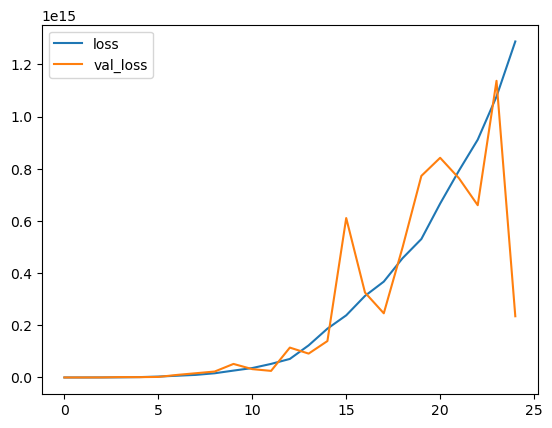

In [17]:
history_plots(r,'loss')

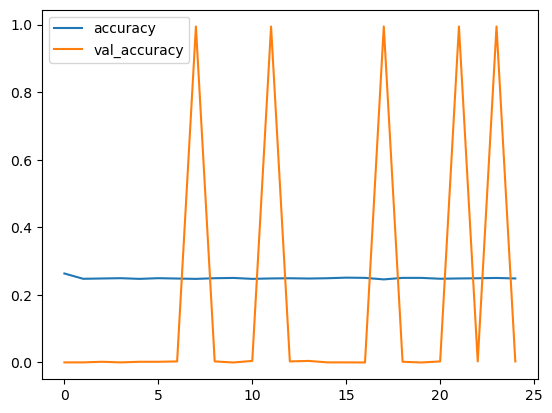

In [12]:
history_plots(r,'accuracy')

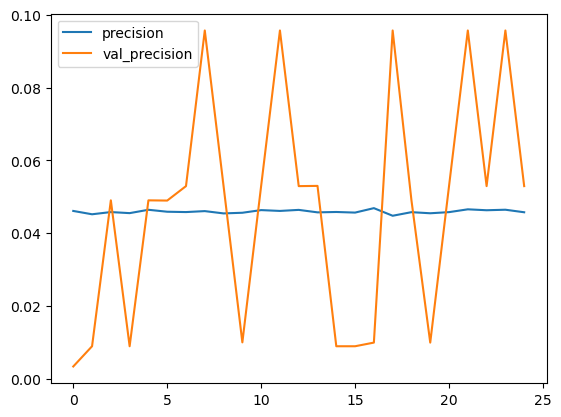

In [14]:
history_plots(r,'precision')

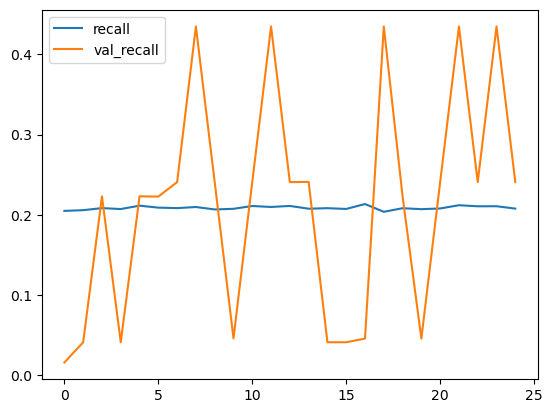

In [15]:
history_plots(r,'recall')

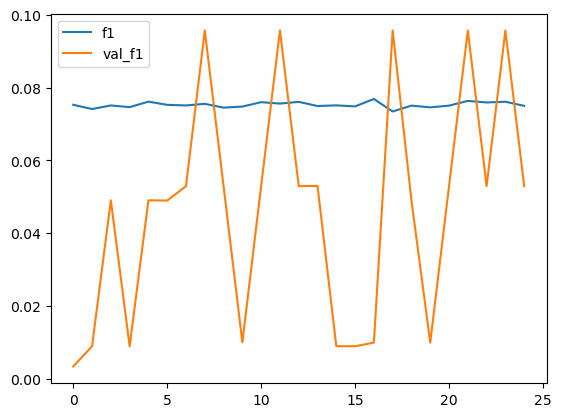

In [18]:
f1_derive(r,'precision','recall')

In [19]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model2= Model(i,x)

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

q = model2.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 44s 39ms/step - loss: 237077.8125 - accuracy: 0.2423 - precision: 0.0456 - recall: 0.1940 - val_loss: 887297.3750 - val_accuracy: 0.0031 - val_precision: 0.0530 - val_recall: 0.2406
Epoch 2/25
1117/1117 [==============================] - 44s 39ms/step - loss: 6545549.0000 - accuracy: 0.2484 - precision: 0.0465 - recall: 0.2109 - val_loss: 11130389.0000 - val_accuracy: 0.0031 - val_precision: 0.0530 - val_recall: 0.2406
Epoch 3/25
1117/1117 [==============================] - 44s 39ms/step - loss: 32131494.0000 - accuracy: 0.2484 - precision: 0.0464 - recall: 0.2112 - val_loss: 64567716.0000 - val_accuracy: 0.0031 - val_precision: 0.0530 - val_recall: 0.2406
Epoch 4/25
1051/1117 [===========================>..] - ETA: 2s - loss: 88473224.0000 - accuracy: 0.2488 - precision: 0.0455 - recall: 0.2072

In [ ]:
history_plots(q,'accuracy')

In [ ]:
history_plots(q,'precision')

In [ ]:
history_plots(q,'recall')

In [ ]:
history_plots(q,'loss')

In [ ]:
f1_derive(q,'precision','recall')

In [ ]:
D=60
m=64
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model3= Model(i,x)

In [ ]:
model3.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

s = model3.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

In [ ]:
history_plots(s,'accuracy')

In [ ]:
history_plots(s,'precision')

In [ ]:
history_plots(s,'recall')

In [ ]:
history_plots(s,'loss')

In [ ]:
f1_derive(s,'precision','recall')

In [ ]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model= Model(i,x)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy',Precision(name='precision'), Recall(name='recall')])

f = model.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

In [ ]:
history_plots(f,'accuracy')

In [ ]:
history_plots(f,'precision')

In [ ]:
history_plots(f,'recall')

In [ ]:
history_plots(f,'loss')

In [ ]:
f1_derive(f,'precision','recall')